# 1. Obtención de datos

In [1]:
! wget http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
! tar -xf aclImdb_v1.tar.gz

--2022-02-07 20:40:11--  http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘aclImdb_v1.tar.gz’

aclImdb_v1.tar.gz   100%[===================>]  80.23M  23.0MB/s    in 4.7s    

2022-02-07 20:40:16 (17.1 MB/s) - ‘aclImdb_v1.tar.gz’ saved [84125825/84125825]



# 2. Exploración de datos

In [2]:
import os
import glob

def read_imdb_data(data_dir='./aclImdb'):
    """Read IMDb movie reviews from given directory.
    
    Directory structure expected:
    - data/
        - train/
            - pos/
            - neg/
        - test/
            - pos/
            - neg/
    
    """

    # Datos y etiquetas que se devolveran en dict anidades replicando la estructura de directorios
    data = {}
    labels = {}

    # Asumimos 2 subdirectorios: train y test
    for data_type in ['train', 'test']:
        data[data_type] = {}
        labels[data_type] = {}

        # Asumimos 2 subdirectorios por sentimmiento (etiqueta): pos, neg
        for sentiment in ['pos', 'neg']:
            data[data_type][sentiment] = []
            labels[data_type][sentiment] = []
            
            # Recogemos los ficheros por directorio
            path = os.path.join(data_dir, data_type, sentiment, '*.txt')
            files = glob.glob(path)
            
            # Leemos los datos y les asignamos a su etiqueta
            for f in files:
                with open(f) as review:
                    data[data_type][sentiment].append(review.read())
                    labels[data_type][sentiment].append(sentiment)
            
            assert len(data[data_type][sentiment]) == len(labels[data_type][sentiment]), \
                    "{}/{} data size does not match labels size".format(data_type, sentiment)
    
    # Devolvemos los datos y etiquetas en diccionarios anidados
    return data, labels


data, labels = read_imdb_data()
print("IMDb reviews: train = {} pos / {} neg, test = {} pos / {} neg".format(
        len(data['train']['pos']), len(data['train']['neg']),
        len(data['test']['pos']), len(data['test']['neg'])))

IMDb reviews: train = 12500 pos / 12500 neg, test = 12500 pos / 12500 neg


In [3]:
data["train"]["pos"][0]

'This was a pretty good movie, I liked it. I thought it was a pretty accurate look at bulimia and how it\'s not about dieting, it\'s about having a pain so deep that they have to find a way to deal with it and they choose this. Beth was a very accurately drawn character and in the scene where she confronts her mom about the eating disorder you can see the pain inside her and hear it in her voice and you know how deep the pain is that she is feeling. I also think one of the best lines in the movie is where Beth yells the words, "It\'s not about you." to her mother. Those words were so true and added so much to that scene in the movie. I think that that scene was definitely the most important scene in that movie.'

In [4]:
data["train"]["neg"][0]

"Eh, not a particular good slasher flick. So-so acting, effects, decent yet familiar and uninventive soundtrack.<br /><br />There are three deaths in close succession near the beginning of the movie that make for a fairly good scene in which it would seem anything goes. Apart from that, there's a lot of characters wandering around, not realizing what's going on, or chasing after red herrings; more killing of time, than of people. There are other deaths, and the killer is an equal opportunity murderer, not partial to any one implement. The killer also likes to set other people up to kill innocent people as well. The identity isn't revealed towards the end, and motive is pretty thin, and we really don't care.<br /><br />Supposedly the movie takes place around Christmas, but this isn't a major factor. One scene gets lit by Christmas lights, that's about it.<br /><br />The movie is rather dark with a muddy picture most of the time, at least on the videotape I watched. Some of the dialog go

In [5]:
!pip install wordcloud

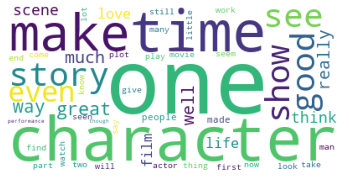

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

from wordcloud import WordCloud, STOPWORDS

sentiment = 'pos'

# Combinamos las reviews para el sentimiento deseado
combined_text = " ".join([review for review in data['train'][sentiment]])

# Inicializamos el wordcloud
wc = WordCloud(background_color='white', max_words=50,
        # Actualizamos las stopwords para incluir palabras comunes del tema
        stopwords = STOPWORDS.update(['br','film','movie']))

plt.imshow(wc.generate(combined_text))
plt.axis('off')
plt.show()

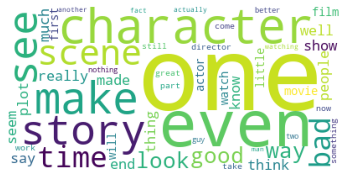

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

from wordcloud import WordCloud, STOPWORDS

sentiment = 'neg'

combined_text = " ".join([review for review in data['train'][sentiment]])

wc = WordCloud(background_color='white', max_words=50,
        stopwords = STOPWORDS.update(['br','film','movie']))

plt.imshow(wc.generate(combined_text))
plt.axis('off')
plt.show()

In [8]:
from sklearn.utils import shuffle

def prepare_imdb_data(data):
    """Prepare training and test sets from IMDb movie reviews."""
    
    # Combinamos los datos de las diferentes etiquetas
    data_train = data['train']['pos'] + data['train']['neg']
    data_test = data['test']['pos'] + data['test']['neg']
    labels_train = labels['train']['pos'] + labels['train']['neg']
    labels_test = labels['test']['pos'] + labels['test']['neg']
    
    # Mezclamos los datos con sus etiquetas
    data_train, labels_train = shuffle(data_train, labels_train)
    data_test, labels_test = shuffle(data_test, labels_test)
    
    # Devolvemos unificado training data, test data, training labels, test labets
    return data_train, data_test, labels_train, labels_test


data_train, data_test, labels_train, labels_test = prepare_imdb_data(data)
print("IMDb reviews (combined): train = {}, test = {}".format(len(data_train), len(data_test)))

IMDb reviews (combined): train = 25000, test = 25000


# 4. Preprocesamiento

In [9]:
# BeautifulSoup to easily remove HTML tags
from bs4 import BeautifulSoup 

# RegEx for removing non-letter characters
import re

# NLTK library for the remaining steps
import nltk
nltk.download("stopwords")   # download list of stopwords (only once; need not run it again)
from nltk.corpus import stopwords # import stopwords

from nltk.stem.porter import *
stemmer = PorterStemmer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [10]:
def review_to_words(review):
    """Convert a raw review string into a sequence of words."""
    
    # Eliminamos las etiquetas HTML
    text = BeautifulSoup(review, "html5lib").get_text()
    # Convertimos a minúscula y quitamos todo lo que no sea texto o números
    text = re.sub(r"[^a-zA-Z0-9]", " ", text.lower())
    # Dividimos por espacios
    words = text.split()
    # Eliminamos stopwords
    words = [w for w in words if w not in stopwords.words("english")]
    # Aplicamos stemming
    words = [PorterStemmer().stem(w) for w in words]

    return words


review_to_words("""This is just a <em>test</em>.<br/><br />
But if it wasn't a test, it would make for a <b>Great</b> movie review!""")

['test', 'test', 'would', 'make', 'great', 'movi', 'review']

In [11]:
import pickle

cache_dir = os.path.join("cache", "sentiment_analysis")
os.makedirs(cache_dir, exist_ok=True)

def preprocess_data(data_train, data_test, labels_train, labels_test,
                    cache_dir=cache_dir, cache_file="preprocessed_data.pkl"):
    """Convert each review to words; read from cache if available."""

    cache_data = None
    if cache_file is not None:
        try:
            with open(os.path.join(cache_dir, cache_file), "rb") as f:
                cache_data = pickle.load(f)
            print("Read preprocessed data from cache file:", cache_file)
        except:
            pass
    
    if cache_data is None:
        words_train = list(map(review_to_words, data_train))
        words_test = list(map(review_to_words, data_test))
        
        if cache_file is not None:
            cache_data = dict(words_train=words_train, words_test=words_test,
                              labels_train=labels_train, labels_test=labels_test)
            with open(os.path.join(cache_dir, cache_file), "wb") as f:
                pickle.dump(cache_data, f)
            print("Wrote preprocessed data to cache file:", cache_file)
    else:
        words_train, words_test, labels_train, labels_test = (cache_data['words_train'],
                cache_data['words_test'], cache_data['labels_train'], cache_data['labels_test'])
    
    return words_train, words_test, labels_train, labels_test


words_train, words_test, labels_train, labels_test = preprocess_data(
        data_train, data_test, labels_train, labels_test)

print("\n--- Raw review ---")
print(data_train[1])
print("\n--- Preprocessed words ---")
print(words_train[1])
print("\n--- Label ---")
print(labels_train[1])

Wrote preprocessed data to cache file: preprocessed_data.pkl

--- Raw review ---
I agree with everyone who says that this series was the best of the 'spy' genre. My husband and I were captivated by it when it first aired in the US and watched every episode. I tried at that time to purchase the series (I did tape all of it) but was told by WGBH that it was not available. I even considered writing to Ian Holm to see if he might have a copy! Like others, I purchased and read the Deighton series (in part to understand the complicated plot.) If the original version ever comes available on DVD, I'll be among the first in line to snap up a copy. Ian Holm's portrayal of the vulnerable but courageous Bernard Samson was amazing. (He is always amazing.)

--- Preprocessed words ---
['agre', 'everyon', 'say', 'seri', 'best', 'spi', 'genr', 'husband', 'captiv', 'first', 'air', 'us', 'watch', 'everi', 'episod', 'tri', 'time', 'purchas', 'seri', 'tape', 'told', 'wgbh', 'avail', 'even', 'consid', 'writ

In [12]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
import joblib

def extract_BoW_features(words_train, words_test, vocabulary_size=5000,
                         cache_dir=cache_dir, cache_file="bow_features.pkl"):
    """Extract Bag-of-Words for a given set of documents, already preprocessed into words."""
    
    cache_data = None
    if cache_file is not None:
        try:
            with open(os.path.join(cache_dir, cache_file), "rb") as f:
                cache_data = joblib.load(f)
            print("Read features from cache file:", cache_file)
        except:
            pass
    
    if cache_data is None:
        vectorizer = CountVectorizer(max_features=vocabulary_size,
                preprocessor=lambda x: x, tokenizer=lambda x: x)  # already preprocessed
        features_train = vectorizer.fit_transform(words_train).toarray()

        features_test = vectorizer.transform(words_test).toarray()
                
        if cache_file is not None:
            vocabulary = vectorizer.vocabulary_
            cache_data = dict(features_train=features_train, features_test=features_test,
                             vocabulary=vocabulary)
            with open(os.path.join(cache_dir, cache_file), "wb") as f:
                joblib.dump(cache_data, f)
            print("Wrote features to cache file:", cache_file)
    else:
        features_train, features_test, vocabulary = (cache_data['features_train'],
                cache_data['features_test'], cache_data['vocabulary'])
    
    return features_train, features_test, vocabulary

features_train, features_test, vocabulary = extract_BoW_features(words_train, words_test)

print("Vocabulary: {} words".format(len(vocabulary)))

import random
print("Sample words: {}".format(random.sample(list(vocabulary.keys()), 8)))

print("\n--- Preprocessed words ---")
print(words_train[5])
print("\n--- Bag-of-Words features ---")
print(features_train[5])
print("\n--- Label ---")
print(labels_train[5])

Wrote features to cache file: bow_features.pkl
Vocabulary: 5000 words
Sample words: ['biblic', 'snl', 'stair', 'uh', 'pour', 'pant', 'chosen', 'plot']

--- Preprocessed words ---
['woodi', 'allen', 'second', 'movi', 'set', 'london', 'tha', 'tarot', 'card', 'murder', 'kill', 'prostitut', 'london', 'aspir', 'journalist', 'sondra', 'pranski', 'scarlett', 'johansson', 'get', 'tip', 'may', 'lord', 'peter', 'lyman', 'hugh', 'jackman', 'start', 'romanc', 'quickli', 'fall', 'love', 'help', 'stage', 'magician', 'sid', 'waterman', 'woodi', 'allen', 'like', 'see', 'like', 'better', 'rate', 'match', 'point', 'last', 'year', 'shorter', 'move', 'much', 'quickli', 'plot', 'old', 'entertain', 'kept', 'guess', 'till', 'end', 'realli', 'comedi', 'mysteri', 'good', 'comed', 'line', 'allen', 'cours', 'one', 'allen', 'best', 'far', 'better', 'worst', 'act', 'part', 'good', 'allen', 'bad', 'play', 'charact', 'million', 'time', 'gotten', 'tiresom', 'johansson', 'jackman', 'great', 'look', 'fantast', 'give', 

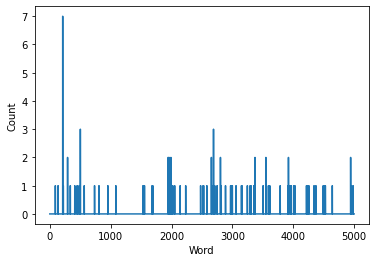

In [13]:
plt.plot(features_train[5,:])
plt.xlabel('Word')
plt.ylabel('Count')
plt.show()

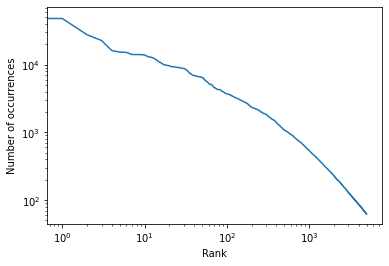

In [14]:
word_freq = features_train.sum(axis=0)

sorted_word_freq = np.sort(word_freq)[::-1]

plt.plot(sorted_word_freq)
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
plt.xlabel('Rank')
plt.ylabel('Number of occurrences')
plt.show()

In [15]:
import sklearn.preprocessing as pr

features_train = pr.normalize(features_train, axis=1)
features_test = pr.normalize(features_test, axis=1)

Debate: ¿Por qué normalizamos los BoW?

# 4. Entrenamiento

In [16]:
from sklearn.ensemble import GradientBoostingClassifier

n_estimators = 32

def classify_gboost(X_train, X_test, y_train, y_test):        
    clf = GradientBoostingClassifier(n_estimators=n_estimators, learning_rate=1.0, max_depth=1, random_state=42)

    clf.fit(X_train, y_train)
    
    print("[{}] Accuracy: train = {}, test = {}".format(
            clf.__class__.__name__,
            clf.score(X_train, y_train),
            clf.score(X_test, y_test)))
    
    return clf


clf2 = classify_gboost(features_train, features_test, labels_train, labels_test)

[GradientBoostingClassifier] Accuracy: train = 0.79472, test = 0.79004


# 5. Pasamos a Deep Learning!

In [17]:
from keras.datasets import imdb

vocabulary_size = 5000

(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=vocabulary_size)
print("Loaded dataset with {} training samples, {} test samples".format(len(X_train), len(X_test)))

17473536/17464789 [==============================] - 0s 0us/step
Loaded dataset with 25000 training samples, 25000 test samples


In [30]:
(X_train_example, y_train_example), (X_test_example, y_test_example) = imdb.load_data(num_words=vocabulary_size)

In [18]:
print("--- Review ---")
print(X_train[0])
print("--- Label ---")
print(y_train[0])

--- Review ---
[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 2, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 2, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 2, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 2, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 2, 19, 178, 32]
--- Label ---
1


In [20]:
word2id = imdb.get_word_index()
id2word = {i: word for word, i in word2id.items()}
print("--- Review (with words) ---")
print([id2word.get(i, " ") for i in X_train[0]])
print("--- Label ---")
print(y_train[0])

--- Review (with words) ---
['the', 'as', 'you', 'with', 'out', 'themselves', 'powerful', 'lets', 'loves', 'their', 'becomes', 'reaching', 'had', 'journalist', 'of', 'lot', 'from', 'anyone', 'to', 'have', 'after', 'out', 'atmosphere', 'never', 'more', 'room', 'and', 'it', 'so', 'heart', 'shows', 'to', 'years', 'of', 'every', 'never', 'going', 'and', 'help', 'moments', 'or', 'of', 'every', 'chest', 'visual', 'movie', 'except', 'her', 'was', 'several', 'of', 'enough', 'more', 'with', 'is', 'now', 'current', 'film', 'as', 'you', 'of', 'mine', 'potentially', 'unfortunately', 'of', 'you', 'than', 'him', 'that', 'with', 'out', 'themselves', 'her', 'get', 'for', 'was', 'camp', 'of', 'you', 'movie', 'sometimes', 'movie', 'that', 'with', 'scary', 'but', 'and', 'to', 'story', 'wonderful', 'that', 'in', 'seeing', 'in', 'character', 'to', 'of', '70s', 'and', 'with', 'heart', 'had', 'shadows', 'they', 'of', 'here', 'that', 'with', 'her', 'serious', 'to', 'have', 'does', 'when', 'from', 'why', 'what

In [31]:
max = 0
mean = []
for example in X_train_example:
  length = len(example)
  mean.append(len(example))
  if length > max:
    max = length

In [33]:
sum(mean) / len(mean)

238.71364

In [32]:
max

2494

In [22]:
from keras.preprocessing import sequence

max_words = 500

X_train = sequence.pad_sequences(X_train, maxlen=max_words)
X_test = sequence.pad_sequences(X_test, maxlen=max_words)

In [23]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout, GRUV2, SimpleRNN

embedding_size = 32
model = Sequential()
model.add(Embedding(vocabulary_size, embedding_size, input_length=max_words))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 32)           160000    
                                                                 
 lstm (LSTM)                 (None, 100)               53200     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 213,301
Trainable params: 213,301
Non-trainable params: 0
_________________________________________________________________
None


In [24]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [26]:
batch_size = 64
num_epochs = 1

X_valid, y_valid = X_train[:batch_size], y_train[:batch_size]  # first batch_size samples
X_train2, y_train2 = X_train[batch_size:], y_train[batch_size:]  # rest for training

model.fit(X_train2, y_train2,
          validation_data=(X_valid, y_valid),
          batch_size=batch_size, epochs=num_epochs)

390/390 [==============================] - 235s 600ms/step - loss: 0.3606 - accuracy: 0.8480 - val_loss: 0.2953 - val_accuracy: 0.8906


In [34]:
model_file = "lstm_model.h5"  # HDF5 file
model.save(os.path.join(cache_dir, model_file))

In [35]:
scores = model.evaluate(X_test, y_test, verbose=0)  # returns loss and other metrics specified in model.compile()
print("Test accuracy:", scores[1])  # scores[1] should correspond to accuracy if you passed in metrics=['accuracy']

Test accuracy: 0.8401200175285339


Vamos a ver con GRU:

In [36]:
embedding_size = 32
model_gru = Sequential()
model_gru.add(Embedding(vocabulary_size, embedding_size, input_length=max_words))
model_gru.add(GRUV2(100))
model_gru.add(Dense(1, activation='sigmoid'))

print(model_gru.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 500, 32)           160000    
                                                                 
 gru (GRU)                   (None, 100)               40200     
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 200,301
Trainable params: 200,301
Non-trainable params: 0
_________________________________________________________________
None


In [37]:
model_gru.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [38]:
batch_size = 64
num_epochs = 1

X_valid, y_valid = X_train[:batch_size], y_train[:batch_size]  # first batch_size samples
X_train2, y_train2 = X_train[batch_size:], y_train[batch_size:]  # rest for training

model_gru.fit(X_train2, y_train2,
          validation_data=(X_valid, y_valid),
          batch_size=batch_size, epochs=num_epochs)

390/390 [==============================] - 200s 506ms/step - loss: 0.4766 - accuracy: 0.7557 - val_loss: 0.2897 - val_accuracy: 0.8906


In [39]:
model_file = "gru_model.h5"  # HDF5 file
model_gru.save(os.path.join(cache_dir, model_file))

In [40]:
scores = model_gru.evaluate(X_test, y_test, verbose=0)  # returns loss and other metrics specified in model.compile()
print("Test accuracy:", scores[1])  # scores[1] should correspond to accuracy if you passed in metrics=['accuracy']

Test accuracy: 0.8521199822425842


Y por último con RNN:

In [41]:
embedding_size = 32
model_rnn = Sequential()
model_rnn.add(Embedding(vocabulary_size, embedding_size, input_length=max_words))
model_rnn.add(SimpleRNN(100))
model_rnn.add(Dense(1, activation='sigmoid'))

print(model_rnn.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 500, 32)           160000    
                                                                 
 simple_rnn (SimpleRNN)      (None, 100)               13300     
                                                                 
 dense_2 (Dense)             (None, 1)                 101       
                                                                 
Total params: 173,401
Trainable params: 173,401
Non-trainable params: 0
_________________________________________________________________
None


In [42]:
model_rnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [43]:
batch_size = 64
num_epochs = 1

X_valid, y_valid = X_train[:batch_size], y_train[:batch_size]  # first batch_size samples
X_train2, y_train2 = X_train[batch_size:], y_train[batch_size:]  # rest for training

model_rnn.fit(X_train2, y_train2,
          validation_data=(X_valid, y_valid),
          batch_size=batch_size, epochs=num_epochs)

390/390 [==============================] - 84s 213ms/step - loss: 0.6651 - accuracy: 0.5775 - val_loss: 0.5762 - val_accuracy: 0.7031


In [44]:
model_file = "rnn_model.h5"  # HDF5 file
model_rnn.save(os.path.join(cache_dir, model_file))

In [45]:
scores = model_rnn.evaluate(X_test, y_test, verbose=0)  # returns loss and other metrics specified in model.compile()
print("Test accuracy:", scores[1])  # scores[1] should correspond to accuracy if you passed in metrics=['accuracy']

Test accuracy: 0.6605600118637085


Y si quitamos el Embedding?

# 5. RNN + word2vec Embedding

In [62]:
import gensim
import multiprocessing as mp

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense,
    Dropout,
    Embedding,
    LSTM,
)
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.preprocessing import LabelEncoder


In [63]:
# WORD2VEC
W2V_SIZE = 300
W2V_WINDOW = 7
# 32
W2V_EPOCH = 5
W2V_MIN_COUNT = 1

# KERAS
SEQUENCE_LENGTH = 500

In [68]:
def generate_tokenizer(train_df):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(train_df)
    vocab_size = len(tokenizer.word_index) + 1
    print(f"Total words: {vocab_size}")
    return tokenizer, vocab_size

In [108]:
def generate_word2vec(train_df):
    documents = [_text.split() for _text in train_df.review]
    w2v_model = gensim.models.word2vec.Word2Vec(
        size=W2V_SIZE,
        window=W2V_WINDOW,
        min_count=W2V_MIN_COUNT,
        workers=mp.cpu_count(),
    )
    w2v_model.build_vocab(documents)

    words = w2v_model.wv.vocab.keys()
    vocab_size = len(words)
    print(f"Vocab size: {vocab_size}")
    w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

    return w2v_model

In [66]:
def generate_embedding(word2vec_model, vocab_size, tokenizer):
    embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
    for word, i in tokenizer.word_index.items():
        if word in word2vec_model.wv:
            embedding_matrix[i] = word2vec_model.wv[word]
    return Embedding(
        vocab_size,
        W2V_SIZE,
        weights=[embedding_matrix],
        input_length=SEQUENCE_LENGTH,
        trainable=False,
    )

In [126]:
(X_train_index, y_train_index), (X_test_index, y_test_index) = imdb.load_data(num_words=vocabulary_size)

In [127]:
word2id = imdb.get_word_index()
id2word = {i: word for word, i in word2id.items()}

X_train_words = []
for index, example in enumerate(X_train_index):
  words = " ".join([id2word.get(i, " ") for i in X_train_index[index]]).strip()
  X_train_words.append(words)

In [128]:
X_test_words = []
for index, example in enumerate(X_test_index):
  words = " ".join([id2word.get(i, " ") for i in X_test_index[index]]).strip()
  X_test_words.append(words)

In [129]:
X_train_words[10]

"the clear fact entertaining there life back br is and show of performance stars br actors film him many should movie reasons to and reading and are in of scenes and and of and out compared not boss yes to and show its disappointed fact raw to it justice by br of where clear fact many your way and with city nice are is along wrong not as it way she but this anything up haven't been by who of choices br of you to as this i'd it and who of shot you'll to love for and of you it is sequels of little quest are seen watched front chemistry to simply alive of chris being it is say easy and cry in chemistry but and all it maybe this is wing film job live of and relief and level names and and to be stops serial and watch is men go this of wing american from and moving is accepted put this of jerry for places so work and watch and lot br that from sometimes wondered make department introduced to wondered from action at turns in low that in gay i'm of chemistry bible i i simply alive it is time d

In [134]:
import pandas as pd

X_train_words = pd.DataFrame(X_train_words, columns=["review"])
X_test_words = pd.DataFrame(X_test_words, columns=["review"])

In [131]:
X_train_words.head()

,review
0,the as you with out themselves powerful lets l...
1,the thought solid thought and do making to is ...
2,the as there in at by br of sure many br of an...
3,the of and and they halfway of identity went p...
4,the sure themes br only acting i i was favouri...


In [132]:
tokenizer, vocab = generate_tokenizer(X_train_words.review)

Total words: 4999


In [135]:
word2vec_model = generate_word2vec(X_train_words)

Vocab size: 4998


In [136]:
from keras.preprocessing import sequence

max_words = 500

X_train_words = sequence.pad_sequences(tokenizer.texts_to_sequences(X_train_words.review), maxlen=max_words)
X_test_words = sequence.pad_sequences(tokenizer.texts_to_sequences(X_test_words.review), maxlen=max_words)

In [137]:
embedding_layer = generate_embedding(word2vec_model, vocab, tokenizer)

In [138]:
model_custom = Sequential()
model_custom.add(embedding_layer)
model_custom.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model_custom.add(Dense(1, activation="sigmoid"))

In [139]:
model_custom.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 500, 300)          1499700   
                                                                 
 lstm_2 (LSTM)               (None, 100)               160400    
                                                                 
 dense_4 (Dense)             (None, 1)                 101       
                                                                 
Total params: 1,660,201
Trainable params: 160,501
Non-trainable params: 1,499,700
_________________________________________________________________


In [140]:
model_custom.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [ ]:
batch_size = 64
num_epochs = 1

X_train_words_valid, y_valid = X_train_words[:batch_size], y_train[:batch_size]  # first batch_size samples
X_train_words2, y_train2 = X_train_words[batch_size:], y_train[batch_size:]  # rest for training

model_custom.fit(X_train_words2, y_train2,
          validation_data=(X_train_words_valid, y_valid),
          batch_size=batch_size, epochs=num_epochs)

240/390 [=================>............] - ETA: 5:43 - loss: 0.5035 - accuracy: 0.7582